# Water level Bottle image Classification

# Your proposed models should reach atleast at  80% of accuracy 

### Imported libraries 

This starter code version for tensor flow however you are allowed to implement similar approach using any other libraries

In [252]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import logging
import numpy as np
import pickle


from tensorflow.keras import layers, Sequential
# Set up logging to capture TensorFlow warnings and errors
logging.basicConfig(level=logging.ERROR, filename='tensorflow.log', filemode='w')


### Set all parameters

In [300]:
BATCH_SIZE = 32#fill the gap
IMAGE_SIZE = 255 #fill the gap
CHANNELS= 3 #fill the gap
EPOCHS= 100 #fill the gap
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
TRAINING_DIR = 'Water Bottle Image Dataset'

### Import data into tensorflow dataset object

In [254]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR,                                                                                                               
    seed=123,
    shuffle=True,#
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 486 files belonging to 3 classes.


In [255]:
class_names = dataset.class_names
class_names

['Full  Water level', 'Half water level', 'Overflowing']

In [256]:
for image_batch, labels_batch in dataset.take(3):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 255, 255, 3)
[0 0 1 0 1 0 2 2 0 0 1 1 0 1 0 0 0 1 0 0 2 0 0 1 1 0 1 0 0 0 1 0]
(32, 255, 255, 3)
[0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 2 0 0 2]
(32, 255, 255, 3)
[1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 2 0 1 0 2 0 1 0 0 0 0 1 0 1 0 2]


### Visualize some of the images from our dataset

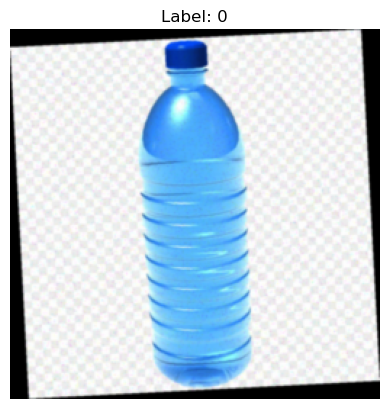

In [257]:
# Iterate through the dataset to get one batch
for images, labels in dataset.take(1):
    # Extract one image and its corresponding label
    image = images[0]  # Assuming batch size is greater than 0
    label = labels[0]

    # Display the image
    plt.figure()
    image = image.numpy().astype("uint8")
    plt.imshow(image)  # Convert to numpy array and uint8 for display
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")  # Turn off axis
    plt.show()

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [258]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.125, test_split=0.125, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    # Calculate the sizes of each partition
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    # Shuffle the dataset if needed
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_size)
    
    # Create partitions
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size).take(test_size)
    
    return train_ds, val_ds, test_ds



In [259]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [260]:
len(train_ds)

12

In [261]:
len(val_ds)

2

In [262]:
len(test_ds)

2

### Cache, Shuffle, and Prefetch the Dataset

In [263]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before you feed your images to network, you would be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).

In [289]:
resize_and_rescale = tf.keras.Sequential([\
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),\
  layers.experimental.preprocessing.Rescaling(1./255),\
])



### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [265]:
# Define the data augmentation Sequential model

data_augmentation = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                    layers.experimental.preprocessing.RandomRotation(0.2),
                    layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
                    layers.experimental.preprocessing.RandomContrast(factor=0.2),
                ])

#### Applying Data Augmentation to Train Dataset

In [267]:
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with your chosen activation function in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [301]:
# Define the model
model = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01), input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01)),
    layers.Conv2D(128, (3, 3), padding='same', activation=layers.LeakyReLU(alpha=0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation=layers.LeakyReLU(alpha=0.01)),
    layers.Dense(3, activation='softmax'),
])


In [302]:
# Build the model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS) # Input shape of the images

model.build(input_shape=(BATCH_SIZE,) + input_shape)
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 255, 255, 32)      896       
                                                                 
 max_pooling2d_115 (MaxPool  (None, 127, 127, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_131 (Conv2D)         (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_116 (MaxPool  (None, 63, 63, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_132 (Conv2D)         (None, 63, 63, 64)        36928     
                                                                 
 max_pooling2d_117 (MaxPool  (None, 31, 31, 64)      

### Compiling the Model
use  Optimizer,losses,and your desired metric

In [303]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



# Fit the Model

In [304]:
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)

Epoch 1/100
12/12 [==============================] - 13s 932ms/step - loss: 9.2930 - accuracy: 0.3436 - val_loss: 0.8063 - val_accuracy: 0.6719
Epoch 2/100
12/12 [==============================] - 12s 946ms/step - loss: 0.8909 - accuracy: 0.6117 - val_loss: 0.7919 - val_accuracy: 0.6875
Epoch 3/100
12/12 [==============================] - 13s 1s/step - loss: 0.8322 - accuracy: 0.6201 - val_loss: 0.7696 - val_accuracy: 0.6875
Epoch 4/100
12/12 [==============================] - 14s 1s/step - loss: 0.8000 - accuracy: 0.6201 - val_loss: 0.6941 - val_accuracy: 0.6875
Epoch 5/100
12/12 [==============================] - 14s 1s/step - loss: 0.8359 - accuracy: 0.6201 - val_loss: 0.7678 - val_accuracy: 0.6875
Epoch 6/100
12/12 [==============================] - 13s 1s/step - loss: 0.8193 - accuracy: 0.6201 - val_loss: 0.7392 - val_accuracy: 0.6875
Epoch 7/100
12/12 [==============================] - 13s 1s/step - loss: 0.7951 - accuracy: 0.6229 - val_loss: 0.7096 - val_accuracy: 0.6875
Epoch 8

## compute model evaluation

In [305]:
scores = model.evaluate(test_ds)

# model.save("my_model0.7031")

2/2 [==============================] - 1s 350ms/step - loss: 0.3327 - accuracy: 0.8750


In [306]:
scores

[0.33272331953048706, 0.875]

### Plotting the Accuracy and Loss Curves

In [307]:
history

In [308]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 12}

In [309]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

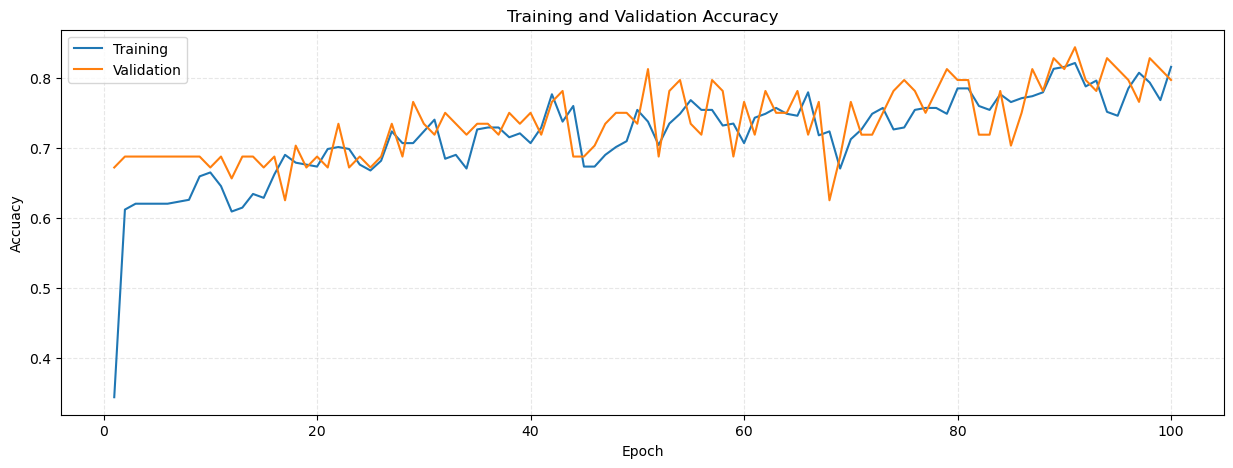

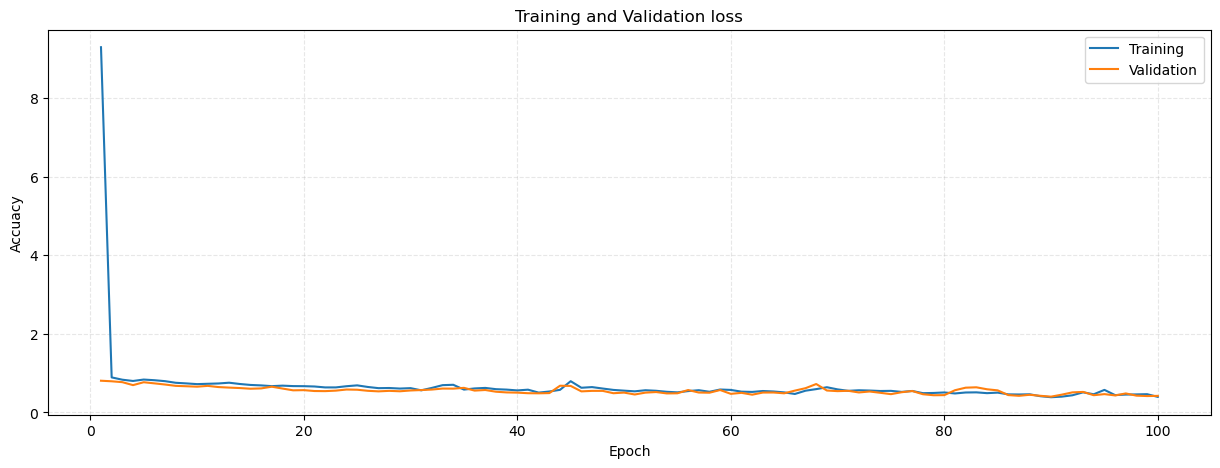

In [317]:
#get your evaluation metrics from history
accuray = history.history.get('accuracy')
loss = history.history.get('loss')

val_accuracy = history.history.get('val_accuracy')
val_loss = history.history.get('val_loss')


plt.figure(figsize = (15,5))
plt.plot(range(1,len(accuray)+1),accuray, label='Training')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy, label = 'Validation')
# plt.xticks(range(1,21))
plt.grid(True, linestyle = '--', alpha = 0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuacy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize = (15,5))
plt.plot(range(1,len(loss)+1),loss, label='Training')
plt.plot(range(1,len(val_loss)+1),val_loss, label = 'Validation')
# plt.xticks(range(1,21))
plt.grid(True, linestyle = '--', alpha = 0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuacy')
plt.title('Training and Validation loss')
plt.show()


# Alexnets to compare

In [319]:


class AlexNet:
    @staticmethod
    def build(input_shape, num_classes):
        model = Sequential([
            # First convolutional layer
            layers.Conv2D(280, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
            layers.BatchNormalization(),

            # Second convolutional layer
            layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
            layers.BatchNormalization(),

            # Third convolutional layer
            layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),

            # Fourth convolutional layer
            layers.Conv2D(384, kernel_size=(3, 3), padding='same', activation='relu'),
            layers.BatchNormalization(),

            # Fifth convolutional layer
            layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
            layers.BatchNormalization(),

            # Flatten the convolutional layers
            layers.Flatten(),

            # First fully connected layer
            layers.Dense(4096, activation='relu'),
            layers.Dropout(0.5),

            # Second fully connected layer
            layers.Dense(4096, activation='relu'),
            layers.Dropout(0.5),

            # Output layer
            layers.Dense(num_classes, activation='softmax')
        ])
        return model


AlexNet = AlexNet()
AlexNet = AlexNet.build(input_shape,3)
# Compile the model
AlexNet.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history_alex = AlexNet.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

# Evaluate the model on the validation set
val_loss_alex, val_acc_alex = AlexNet.evaluate(test_ds)
print("Validation Loss:", val_loss_alex)
print("Validation Accuracy:", val_acc_alex)



Epoch 1/100
12/12 [==============================] - 65s 5s/step - loss: 15.6234 - accuracy: 0.5056 - val_loss: 24414.3652 - val_accuracy: 0.6875
Epoch 2/100
12/12 [==============================] - 47s 4s/step - loss: 11.4649 - accuracy: 0.5140 - val_loss: 2383.6460 - val_accuracy: 0.6875
Epoch 3/100
12/12 [==============================] - 45s 4s/step - loss: 5.5867 - accuracy: 0.5587 - val_loss: 3509.1177 - val_accuracy: 0.6875
Epoch 4/100
12/12 [==============================] - 87s 8s/step - loss: 5.9357 - accuracy: 0.5559 - val_loss: 989.2114 - val_accuracy: 0.6875
Epoch 5/100
12/12 [==============================] - 161s 12s/step - loss: 2.8863 - accuracy: 0.5838 - val_loss: 419.4700 - val_accuracy: 0.6875
Epoch 6/100
12/12 [==============================] - 181s 15s/step - loss: 2.3879 - accuracy: 0.5782 - val_loss: 111.4071 - val_accuracy: 0.6875
Epoch 7/100
12/12 [==============================] - 43s 4s/step - loss: 2.0875 - accuracy: 0.5894 - val_loss: 44.2833 - val_accurac

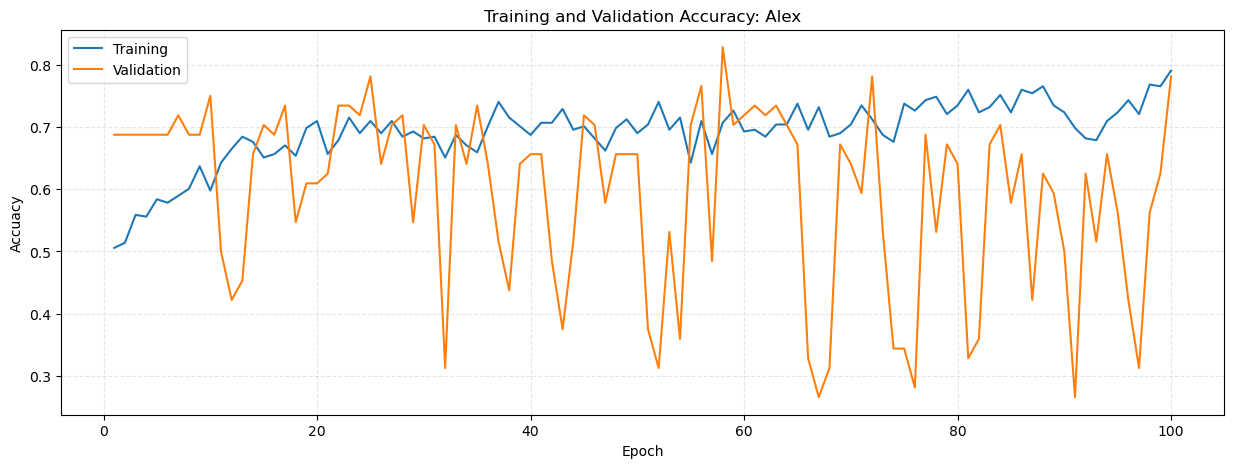

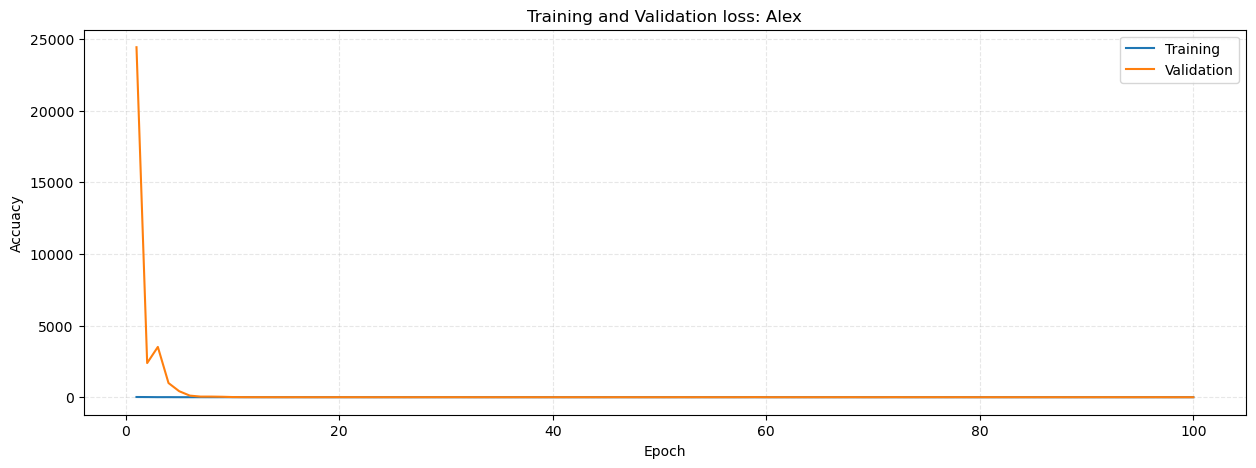

In [320]:
#get your evaluation metrics from history
accuray_alex = history_alex.history.get('accuracy')
loss_alex = history_alex.history.get('loss')

val_accuracy_alex = history_alex.history.get('val_accuracy')
val_loss_alex = history_alex.history.get('val_loss')


plt.figure(figsize = (15,5))
plt.plot(range(1,len(accuray_alex)+1),accuray_alex, label='Training')
plt.plot(range(1,len(val_accuracy_alex)+1),val_accuracy_alex, label = 'Validation')
# plt.xticks(range(1,21))
plt.grid(True, linestyle = '--', alpha = 0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuacy')
plt.title('Training and Validation Accuracy: Alex')
plt.show()

plt.figure(figsize = (15,5))
plt.plot(range(1,len(loss_alex)+1),loss_alex, label='Training')
plt.plot(range(1,len(val_loss_alex)+1),val_loss_alex, label = 'Validation')
# plt.xticks(range(1,21))
plt.grid(True, linestyle = '--', alpha = 0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuacy')
plt.title('Training and Validation loss: Alex')
plt.show()


### Our model is better: Run prediction on a sample image

first image to predict


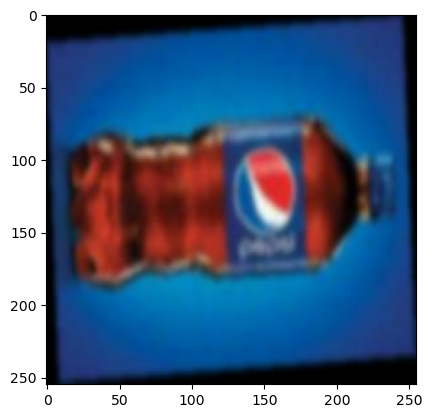

actual label: Full  Water level
1/1 [==============================] - 0s 184ms/step
predicted label: Full  Water level
first image to predict


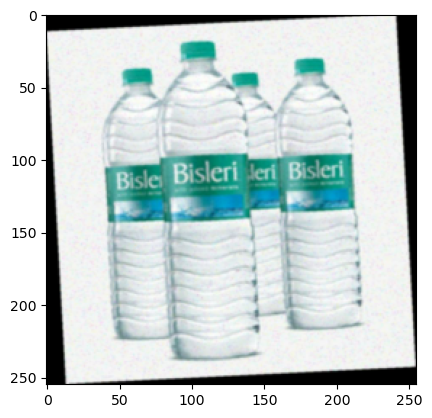

actual label: Full  Water level
1/1 [==============================] - 0s 190ms/step
predicted label: Full  Water level


In [286]:

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    # print(first_image)
    
    print("first image to predict")
    plt.imshow(first_image)
    plt.show()
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [287]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 23ms/step


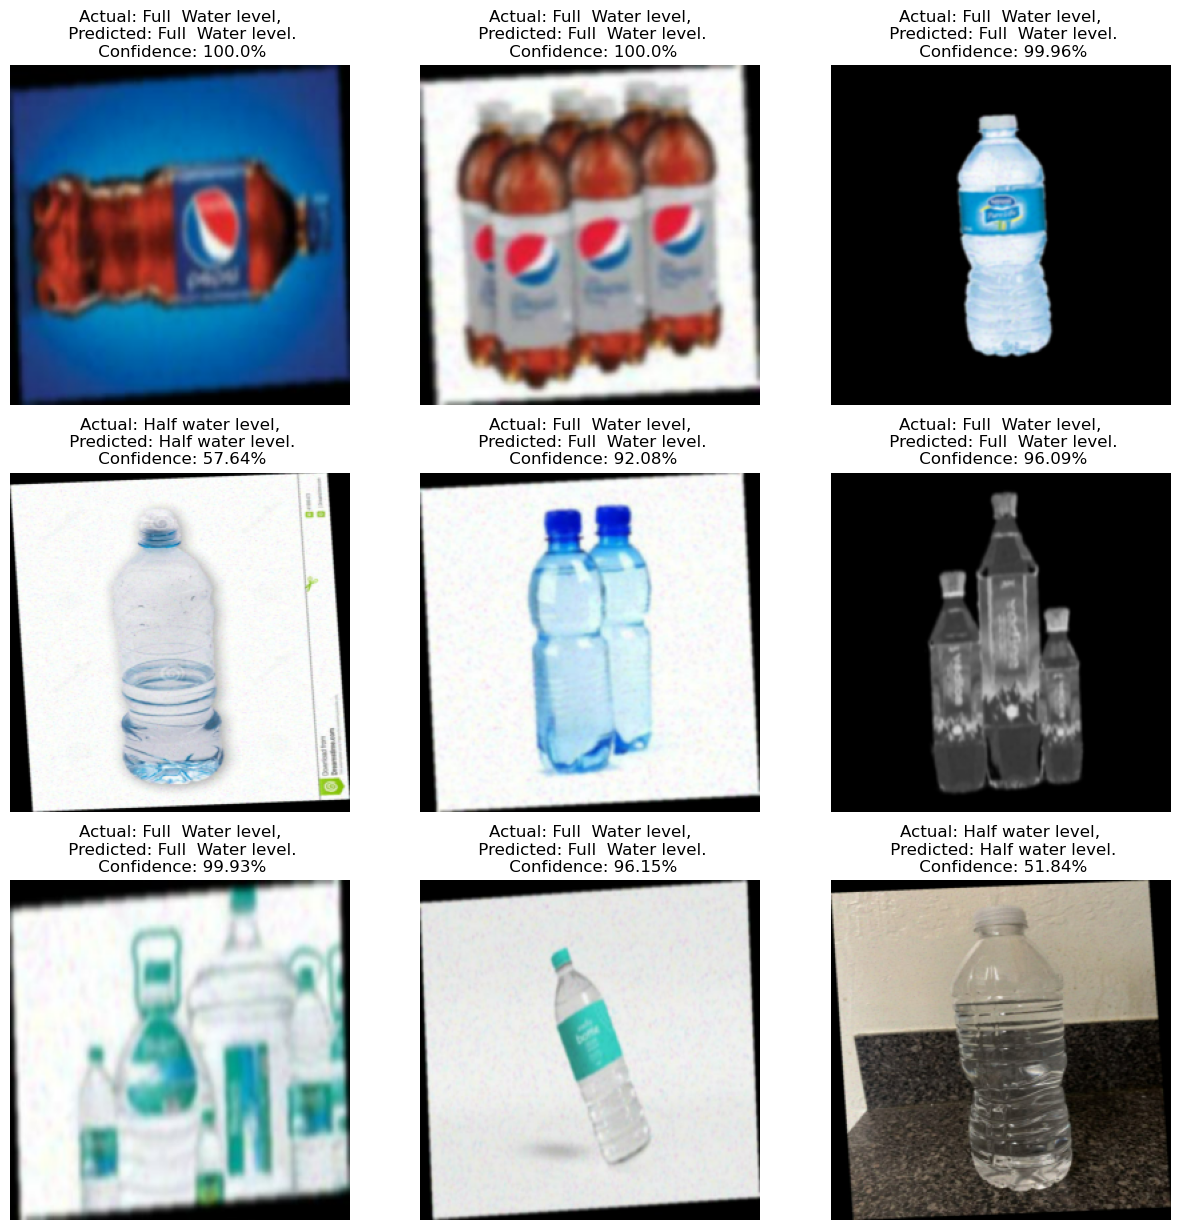

In [288]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [282]:
# Print dataset details
print("Dataset details:")
print("Number of classes:", len(class_names))
print("Class names:", class_names)
print("Number of training examples:", tf.data.Dataset.cardinality(train_ds))
print("Number of validation examples:", tf.data.Dataset.cardinality(val_ds))
print("Number of test examples:", tf.data.Dataset.cardinality(test_ds))

# Print model details
print("Model details:")
print("Input shape:", model.input_shape)
print("Output shape:", model.output_shape)
print("Number of layers:", len(model.layers))


Dataset details:
Number of classes: 3
Class names: ['Full  Water level', 'Half water level', 'Overflowing']
Number of training examples: tf.Tensor(12, shape=(), dtype=int64)
Number of validation examples: tf.Tensor(2, shape=(), dtype=int64)
Number of test examples: tf.Tensor(2, shape=(), dtype=int64)
Model details:
Input shape: (None, 255, 255, 3)
Output shape: (None, 3)
Number of layers: 13
